In [1]:
# Import the libraries
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Connect to MySQL database
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="cfdl@2021",
    database="ecommerce"
)

cursor = connection.cursor()

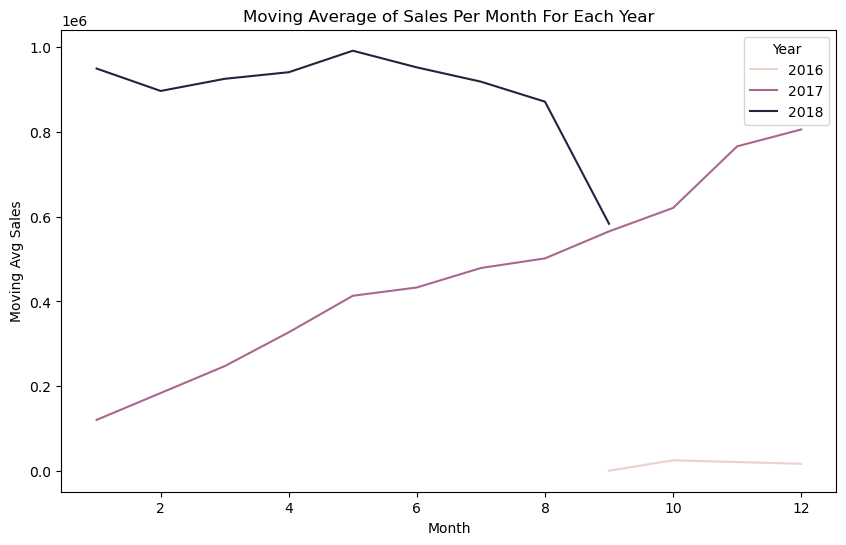

In [3]:
# 1. Calculate the moving average of sales per month for each year.
cursor.execute("""
SELECT YEAR(o.order_purchase_timestamp) as year, 
       MONTH(o.order_purchase_timestamp) as month, 
       AVG(SUM(oi.price)) OVER(PARTITION BY YEAR(o.order_purchase_timestamp) 
                               ORDER BY MONTH(o.order_purchase_timestamp) 
                               ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as moving_avg_sales 
FROM order_items oi 
JOIN orders o ON oi.order_id = o.order_id 
GROUP BY year, month;
""")
result = cursor.fetchall()

# Convert the result to a DataFrame
moving_avg_df = pd.DataFrame(result, columns=['Year', 'Month', 'Moving Avg Sales'])

# Plot the moving average of sales per month for each year as a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=moving_avg_df, x='Month', y='Moving Avg Sales', hue='Year')
plt.title('Moving Average of Sales Per Month For Each Year')
plt.xlabel('Month')
plt.ylabel('Moving Avg Sales')
plt.show()

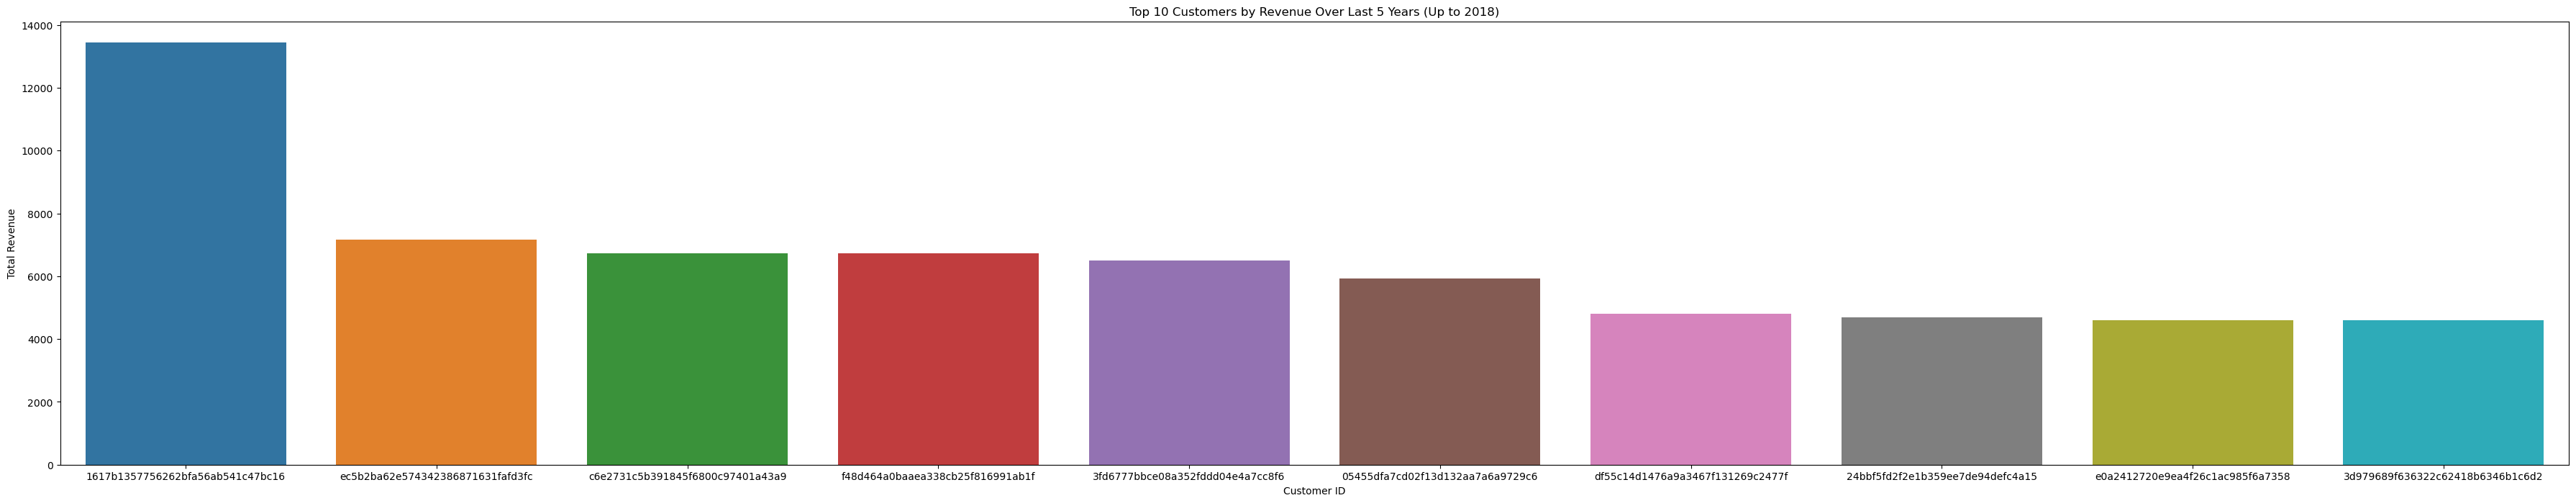

In [4]:
# 2. Identify the top 10 customers who generated the most revenue over the last 5 years.
cursor.execute("SELECT MAX(YEAR(order_purchase_timestamp)) FROM orders;")
last_available_year = cursor.fetchone()[0]

# Identify the top 10 customers who generated the most revenue over the last 5 years
if last_available_year is not None:
    cursor.execute(f"""
    SELECT o.customer_id, SUM(oi.price) as total_revenue 
    FROM order_items oi 
    JOIN orders o ON oi.order_id = o.order_id 
    WHERE YEAR(o.order_purchase_timestamp) BETWEEN {last_available_year} - 4 AND {last_available_year}
    GROUP BY o.customer_id 
    ORDER BY total_revenue DESC 
    LIMIT 10;
    """)
    result = cursor.fetchall()

    # Check if result is empty
    if not result:
        print(f"No data found for the top 10 customers in the last 5 years up to {last_available_year}.")
    else:
        # Convert the result to a DataFrame
        top_customers_df = pd.DataFrame(result, columns=['Customer ID', 'Total Revenue'])

        # Plot the top 10 customers by revenue over the last 5 years as a bar plot
        plt.figure(figsize=(45, 8))
        sns.barplot(data=top_customers_df, x='Customer ID', y='Total Revenue')
        plt.title(f'Top 10 Customers by Revenue Over Last 5 Years (Up to {last_available_year})')
        plt.xlabel('Customer ID')
        plt.ylabel('Total Revenue')
        plt.show()
else:
    print("No data available in the orders table.")


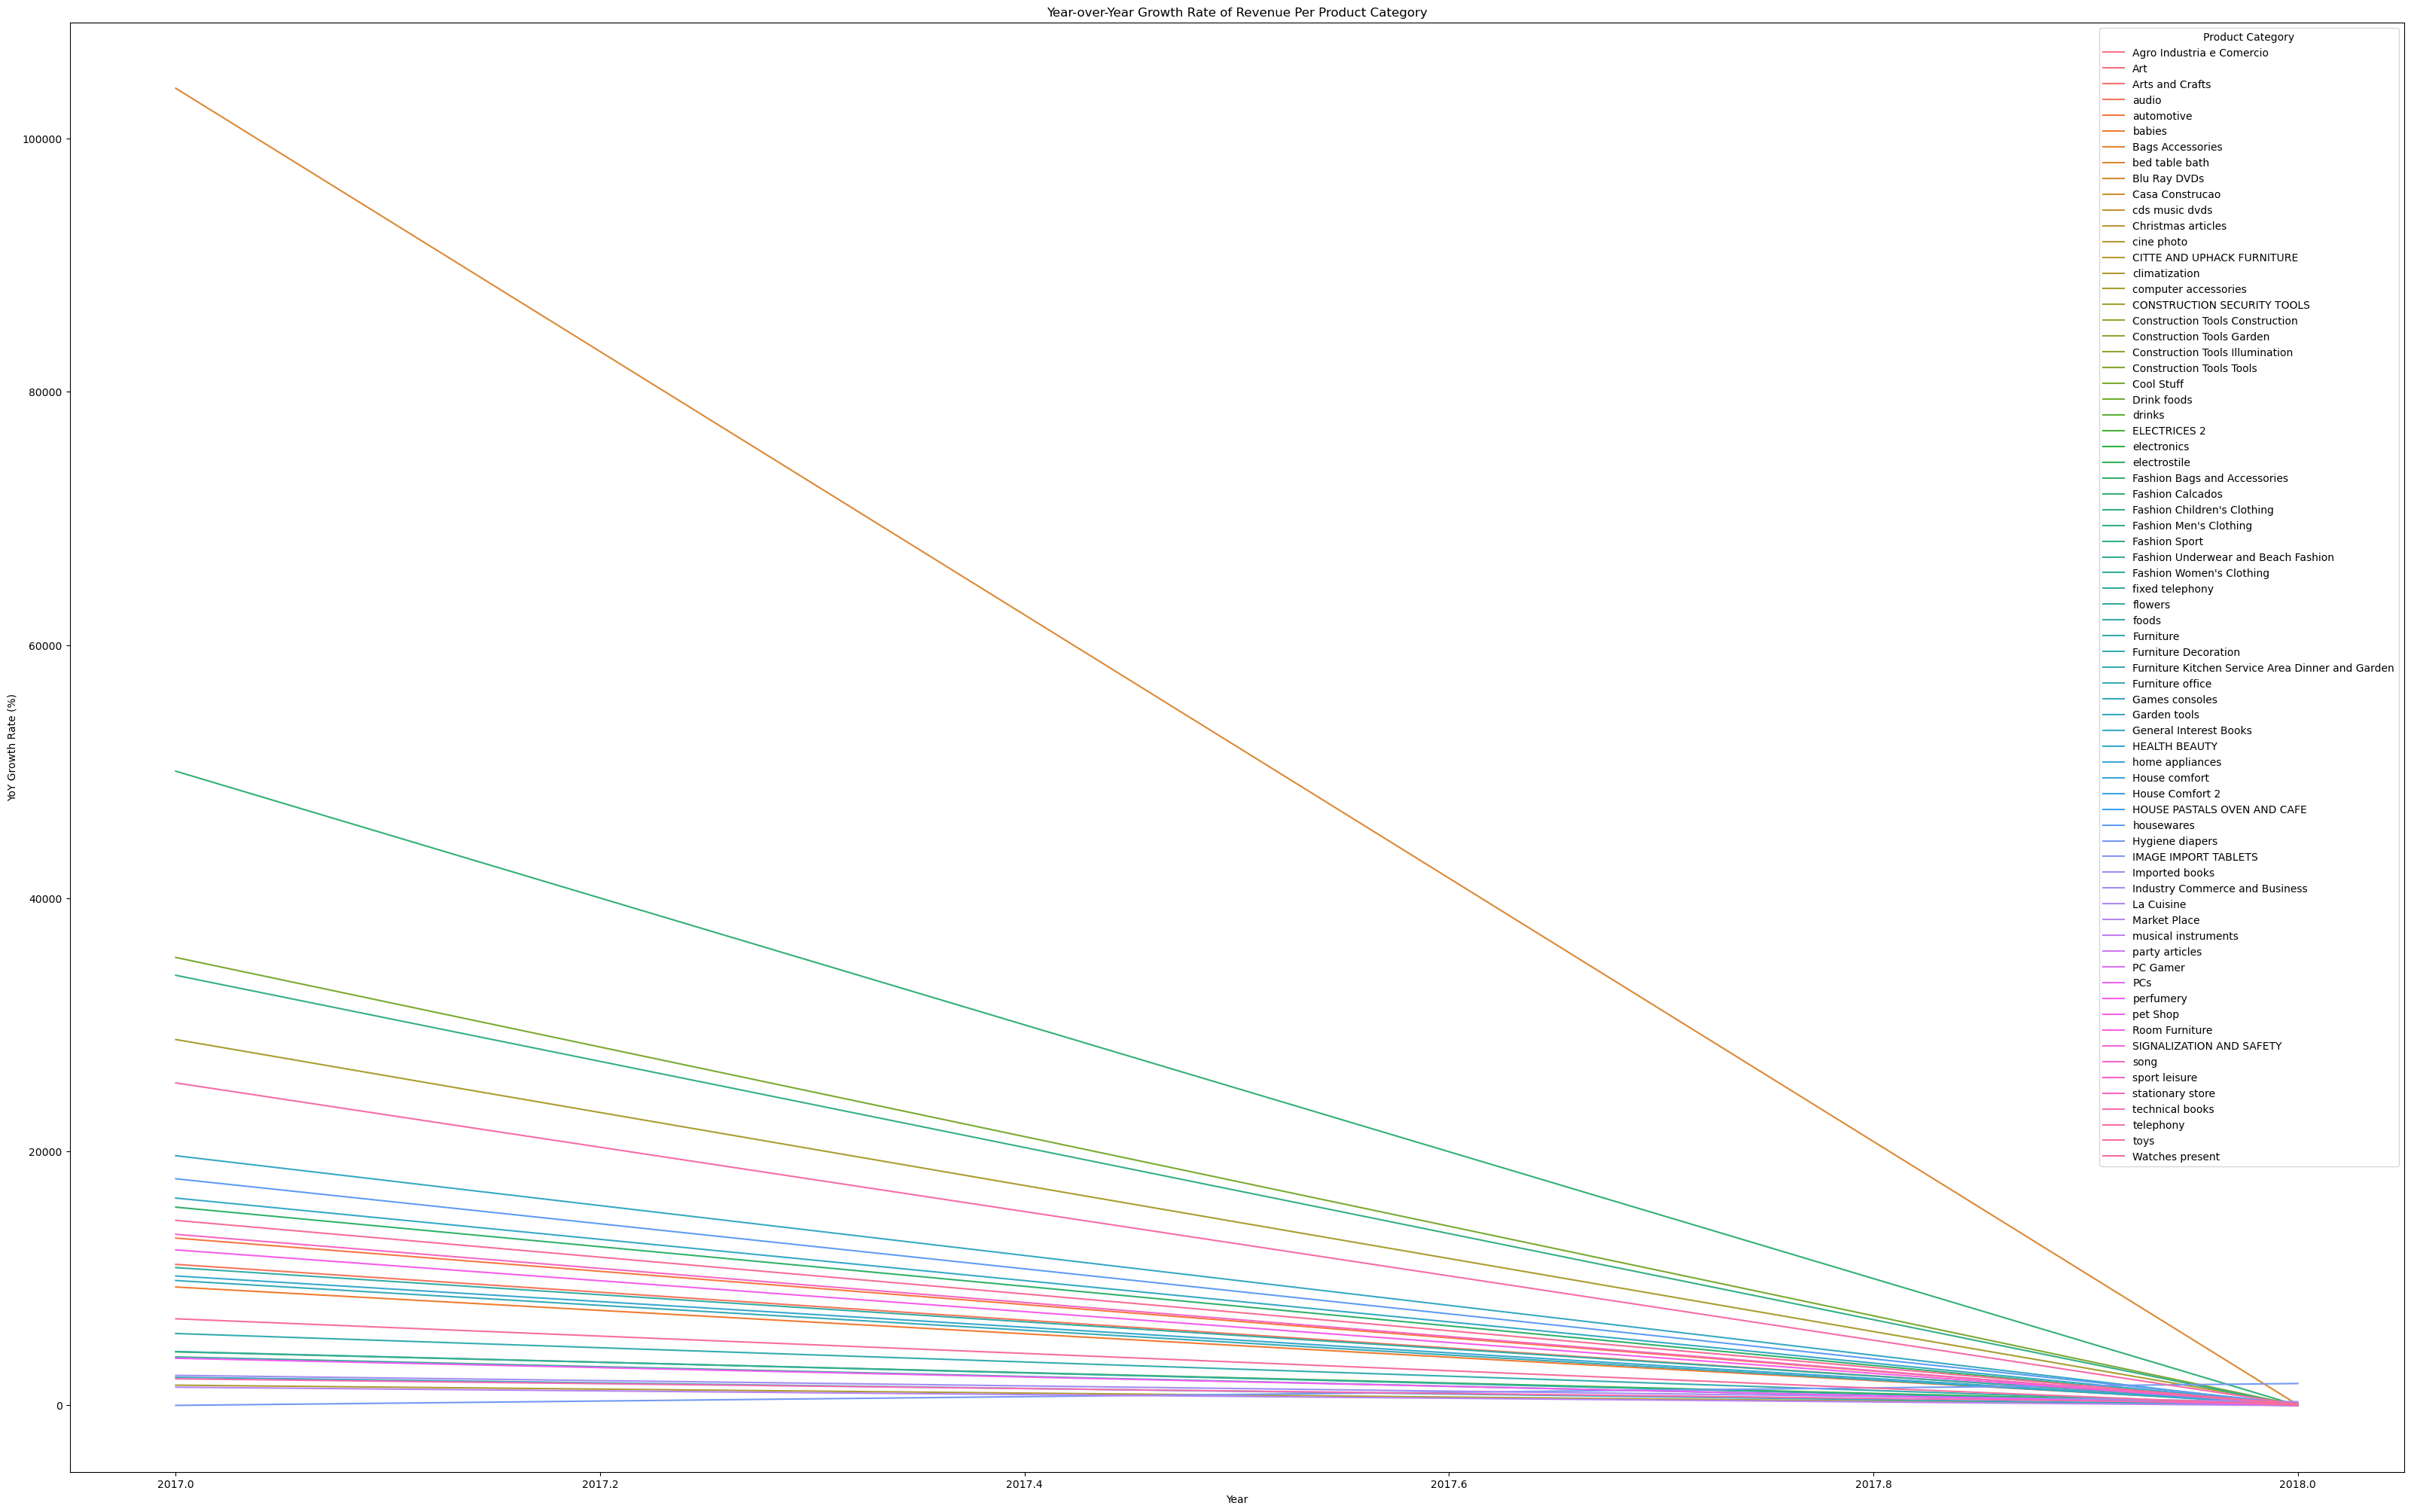

In [5]:
# 3. Calculate the year-over-year growth rate of revenue per product category.
cursor.execute("""
SELECT p.product_category, 
       YEAR(o.order_purchase_timestamp) as year, 
       SUM(oi.price) as total_revenue, 
       LAG(SUM(oi.price)) OVER (PARTITION BY p.product_category
                                ORDER BY YEAR(o.order_purchase_timestamp)) as prev_year_revenue 
FROM order_items oi 
JOIN products p ON oi.product_id = p.product_id 
JOIN orders o ON oi.order_id = o.order_id 
GROUP BY p.product_category, year;
""")
result = cursor.fetchall()

# Convert the result to a DataFrame
growth_rate_df = pd.DataFrame(result, columns=['Product Category', 'Year', 'Total Revenue', 'Prev Year Revenue'])

# Calculate the year-over-year growth rate
growth_rate_df['YoY Growth Rate'] = ((growth_rate_df['Total Revenue'] - growth_rate_df['Prev Year Revenue']) / growth_rate_df['Prev Year Revenue']) * 100
growth_rate_df = growth_rate_df.dropna()

# Plot the year-over-year growth rate of revenue per product category as a line plot
plt.figure(figsize=(40, 25))
sns.lineplot(data=growth_rate_df, x='Year', y='YoY Growth Rate', hue='Product Category')
plt.title('Year-over-Year Growth Rate of Revenue Per Product Category')
plt.xlabel('Year')
plt.ylabel('YoY Growth Rate (%)')
plt.show()

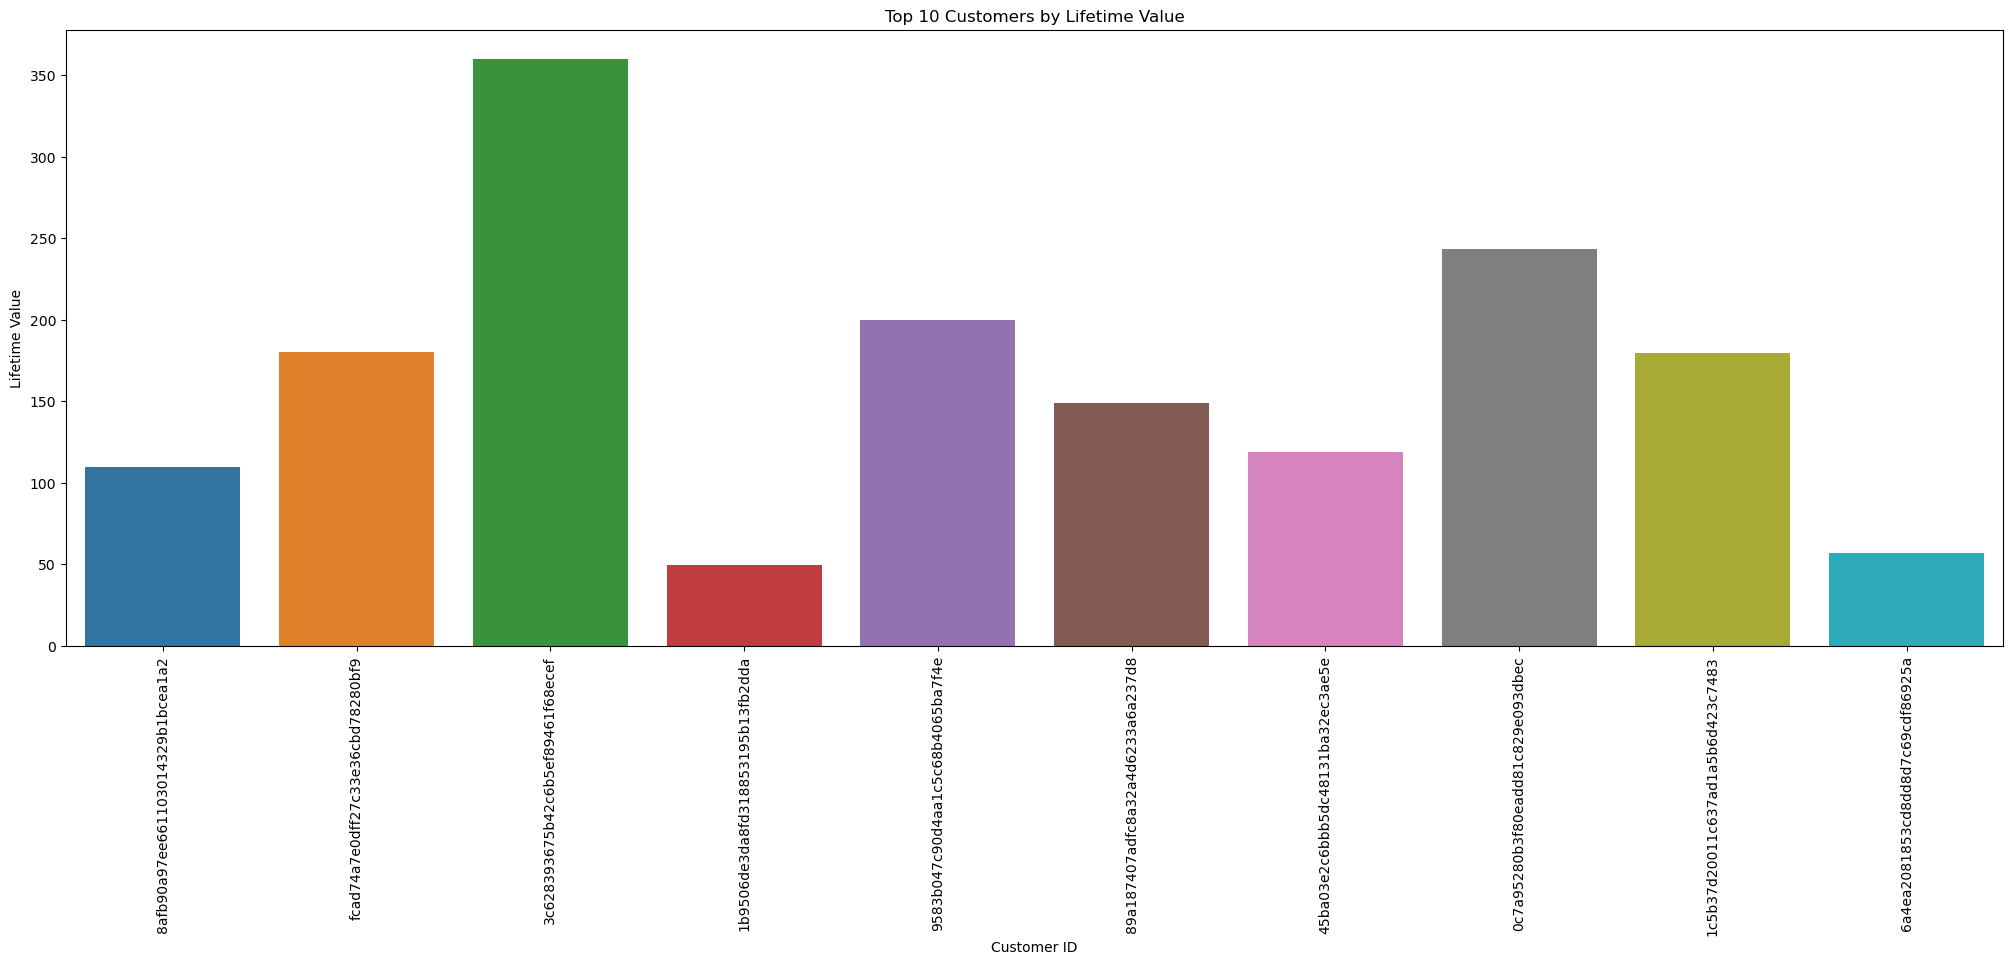

In [6]:
# 4. Determine the lifetime value of each customer.
cursor.execute("""
SELECT o.customer_id, SUM(oi.price) as lifetime_value 
FROM order_items oi 
JOIN orders o ON oi.order_id = o.order_id 
GROUP BY o.customer_id;
""")
result = cursor.fetchall()

# Convert the result to a DataFrame
lifetime_value_df = pd.DataFrame(result, columns=['Customer ID', 'Lifetime Value'])

# Plot the top 10 customers by lifetime value as a bar plot
plt.figure(figsize=(25, 8))
sns.barplot(data=lifetime_value_df.head(10), x='Customer ID', y='Lifetime Value')
plt.title('Top 10 Customers by Lifetime Value')
plt.xlabel('Customer ID')
plt.ylabel('Lifetime Value')
plt.xticks(rotation=90)
plt.show()

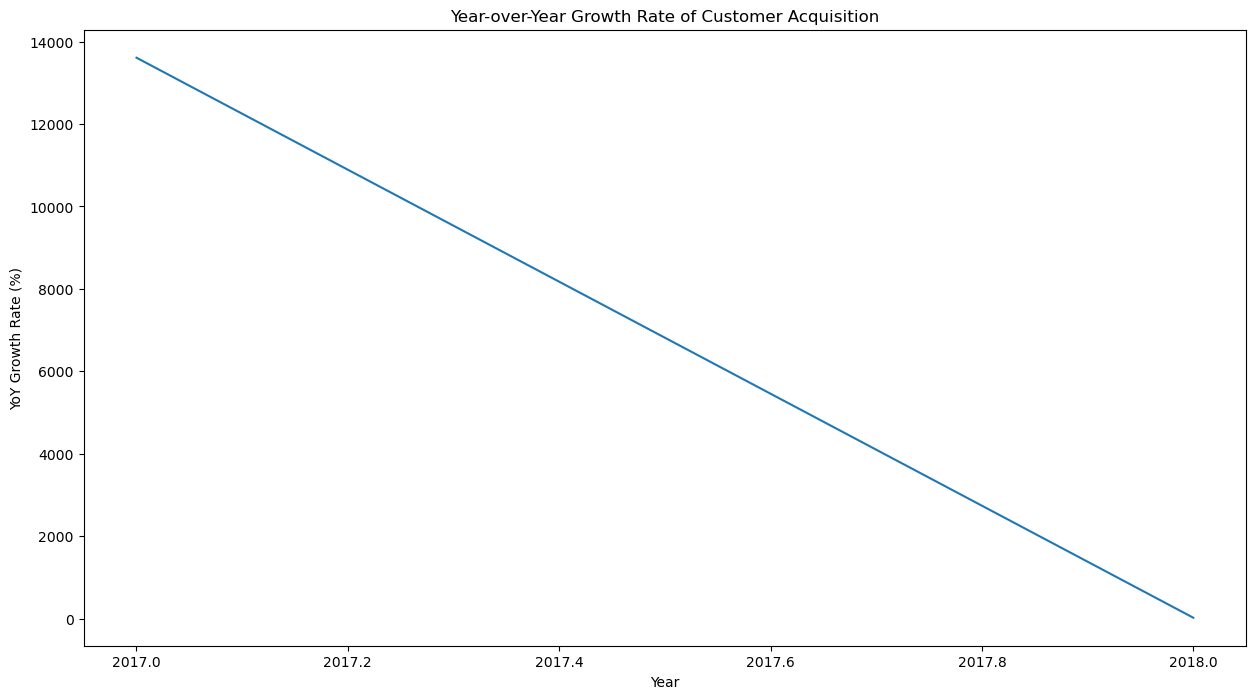

In [7]:
# 5. Calculate the year-over-year growth rate of customer acquisition.
cursor.execute("""
SELECT YEAR(o.order_purchase_timestamp) as year, 
       COUNT(DISTINCT o.customer_id) as new_customers, 
       LAG(COUNT(DISTINCT o.customer_id)) OVER (ORDER BY YEAR(o.order_purchase_timestamp)) as prev_year_customers 
FROM orders o 
GROUP BY year;
""")
result = cursor.fetchall()

# Convert the result to a DataFrame
customer_growth_df = pd.DataFrame(result, columns=['Year', 'New Customers', 'Prev Year Customers'])

# Calculate the year-over-year growth rate
customer_growth_df['YoY Growth Rate'] = ((customer_growth_df['New Customers'] - customer_growth_df['Prev Year Customers']) / customer_growth_df['Prev Year Customers']) * 100
customer_growth_df = customer_growth_df.dropna()

# Plot the year-over-year growth rate of customer acquisition as a line plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=customer_growth_df, x='Year', y='YoY Growth Rate')
plt.title('Year-over-Year Growth Rate of Customer Acquisition')
plt.xlabel('Year')
plt.ylabel('YoY Growth Rate (%)')
plt.show()

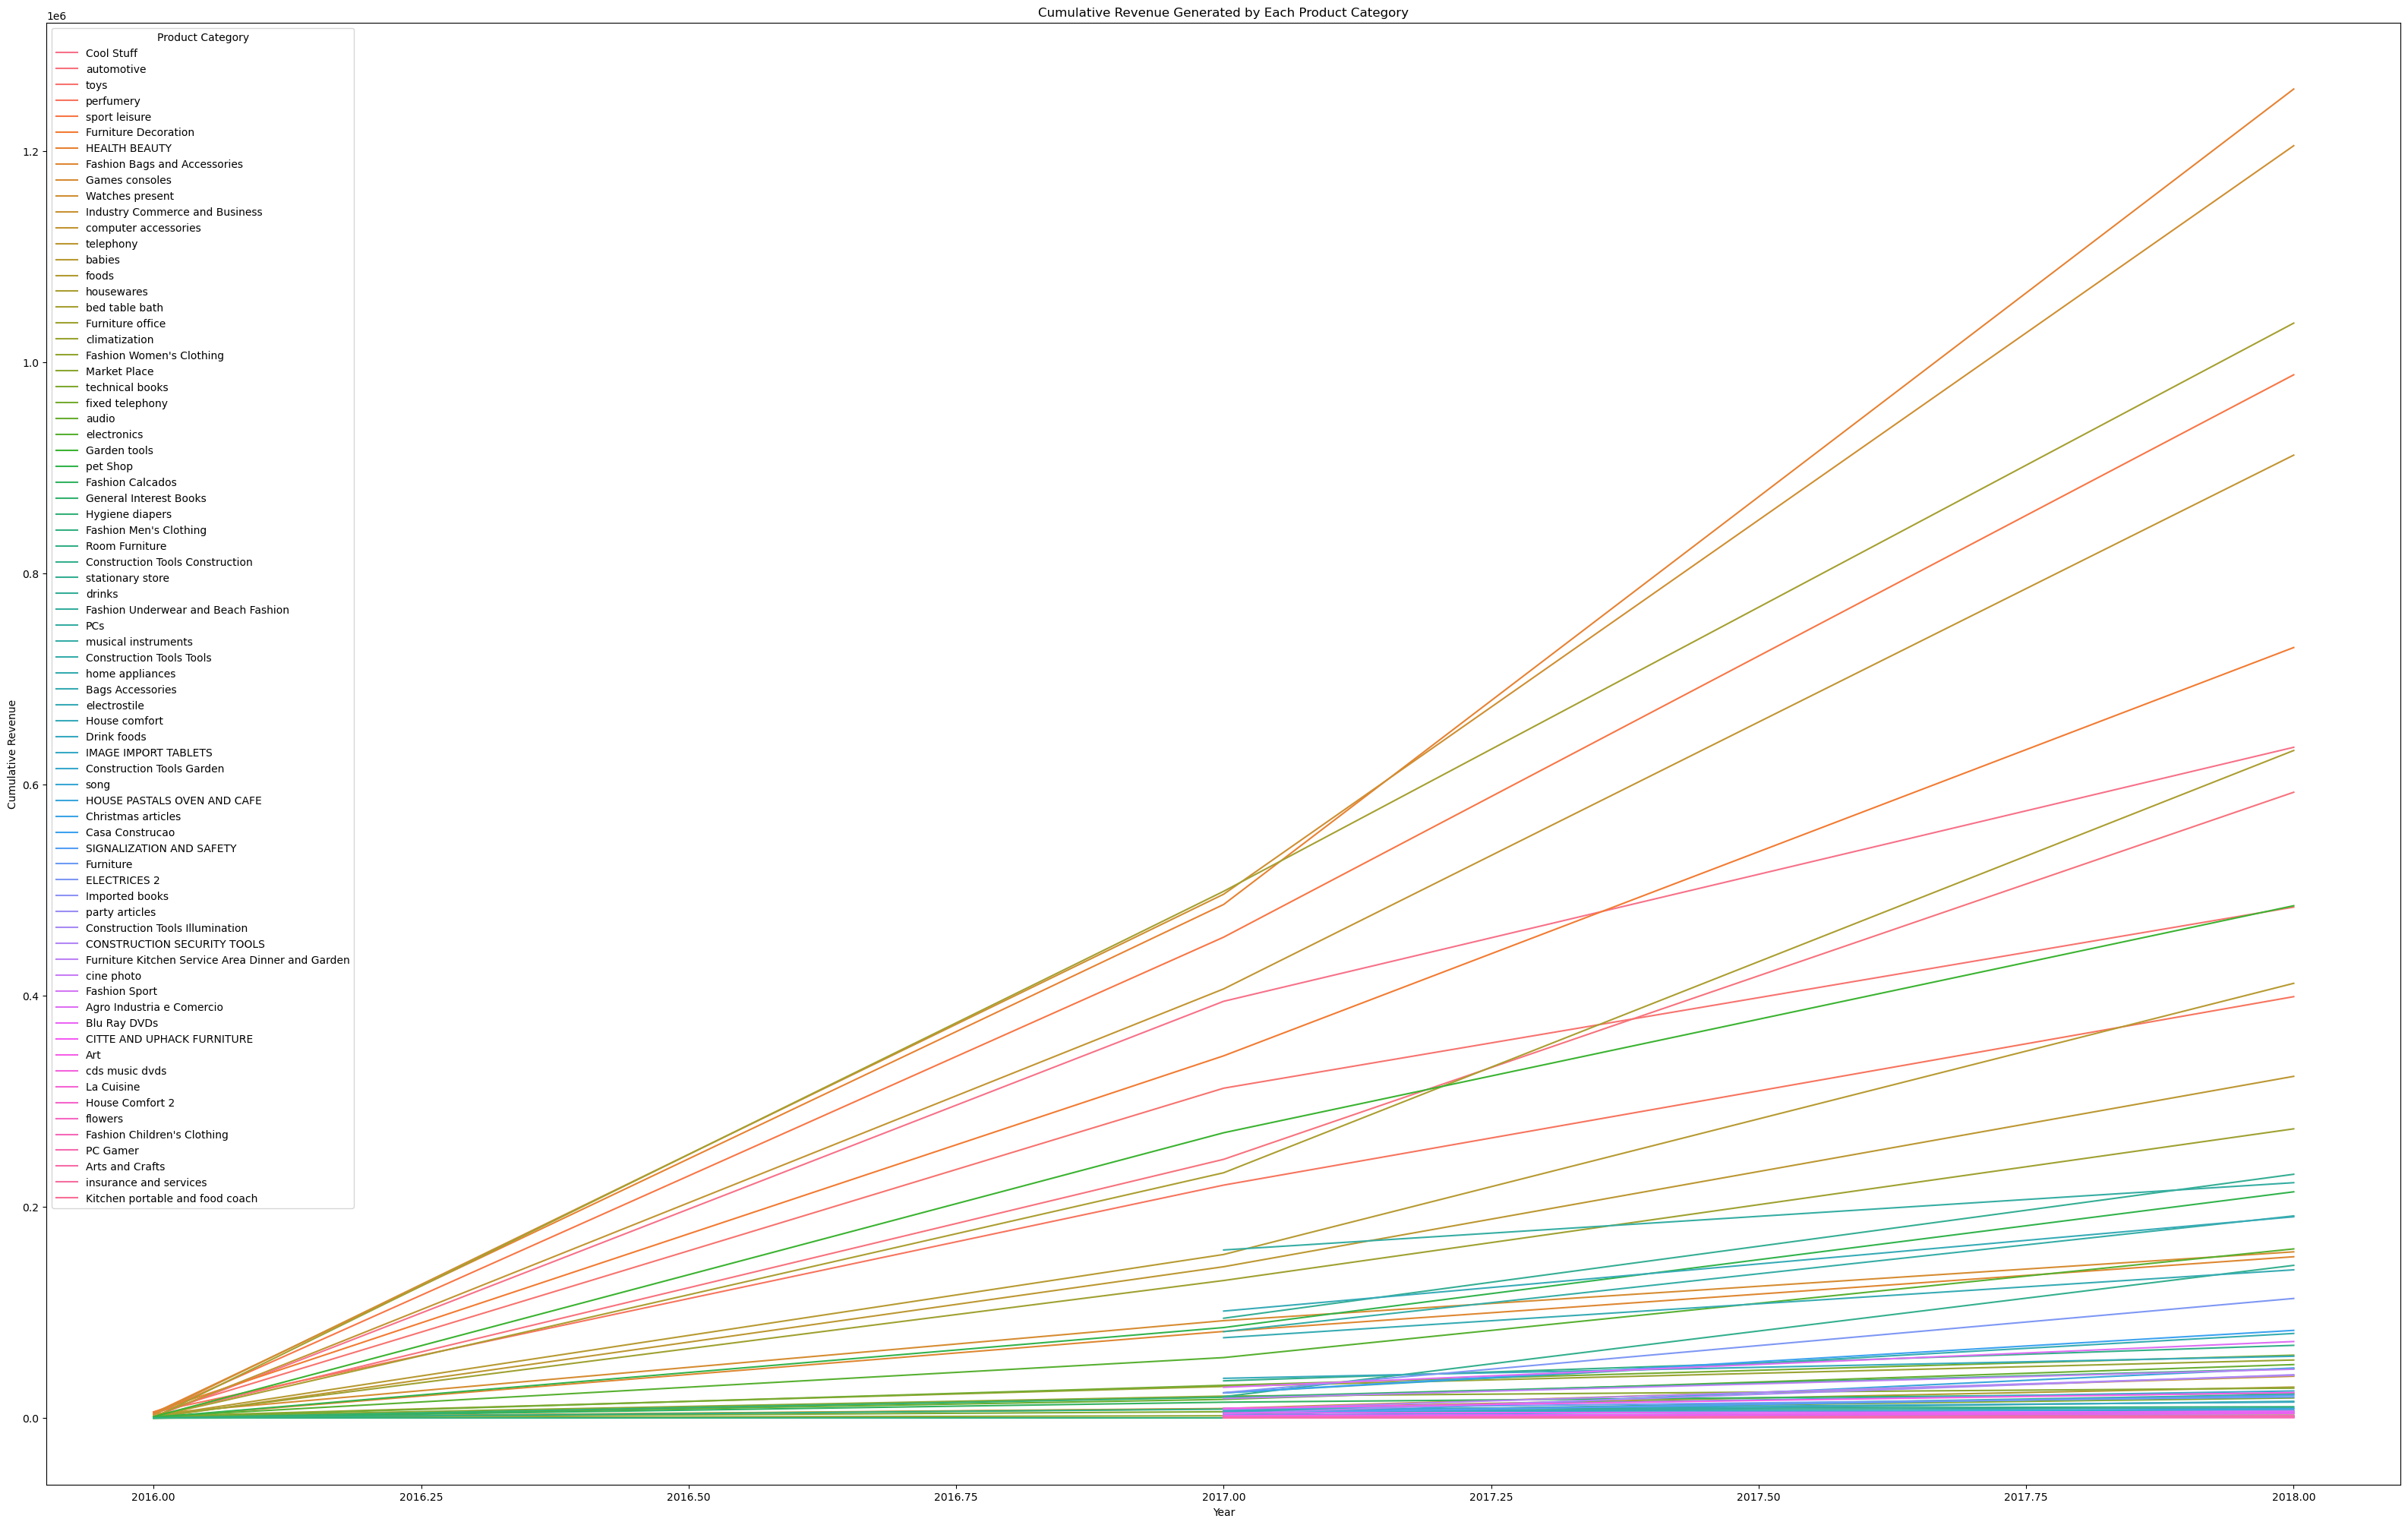

In [8]:
# 6. Calculate the cumulative revenue generated by each product category.
cursor.execute("""
SELECT p.product_category, 
       YEAR(o.order_purchase_timestamp) as year, 
       SUM(oi.price) as total_revenue 
FROM order_items oi 
JOIN products p ON oi.product_id = p.product_id 
JOIN orders o ON oi.order_id = o.order_id 
GROUP BY p.product_category, year 
ORDER BY year ASC;
""")
result = cursor.fetchall()

# Convert the result to a DataFrame
cumulative_revenue_df = pd.DataFrame(result, columns=['Product Category', 'Year', 'Total Revenue'])

# Calculate the cumulative revenue
cumulative_revenue_df['Cumulative Revenue'] = cumulative_revenue_df.groupby('Product Category')['Total Revenue'].cumsum()

# Plot the cumulative revenue generated by each product category as a line plot
plt.figure(figsize=(40, 25))
sns.lineplot(data=cumulative_revenue_df, x='Year', y='Cumulative Revenue', hue='Product Category')
plt.title('Cumulative Revenue Generated by Each Product Category')
plt.xlabel('Year')
plt.ylabel('Cumulative Revenue')
plt.show()

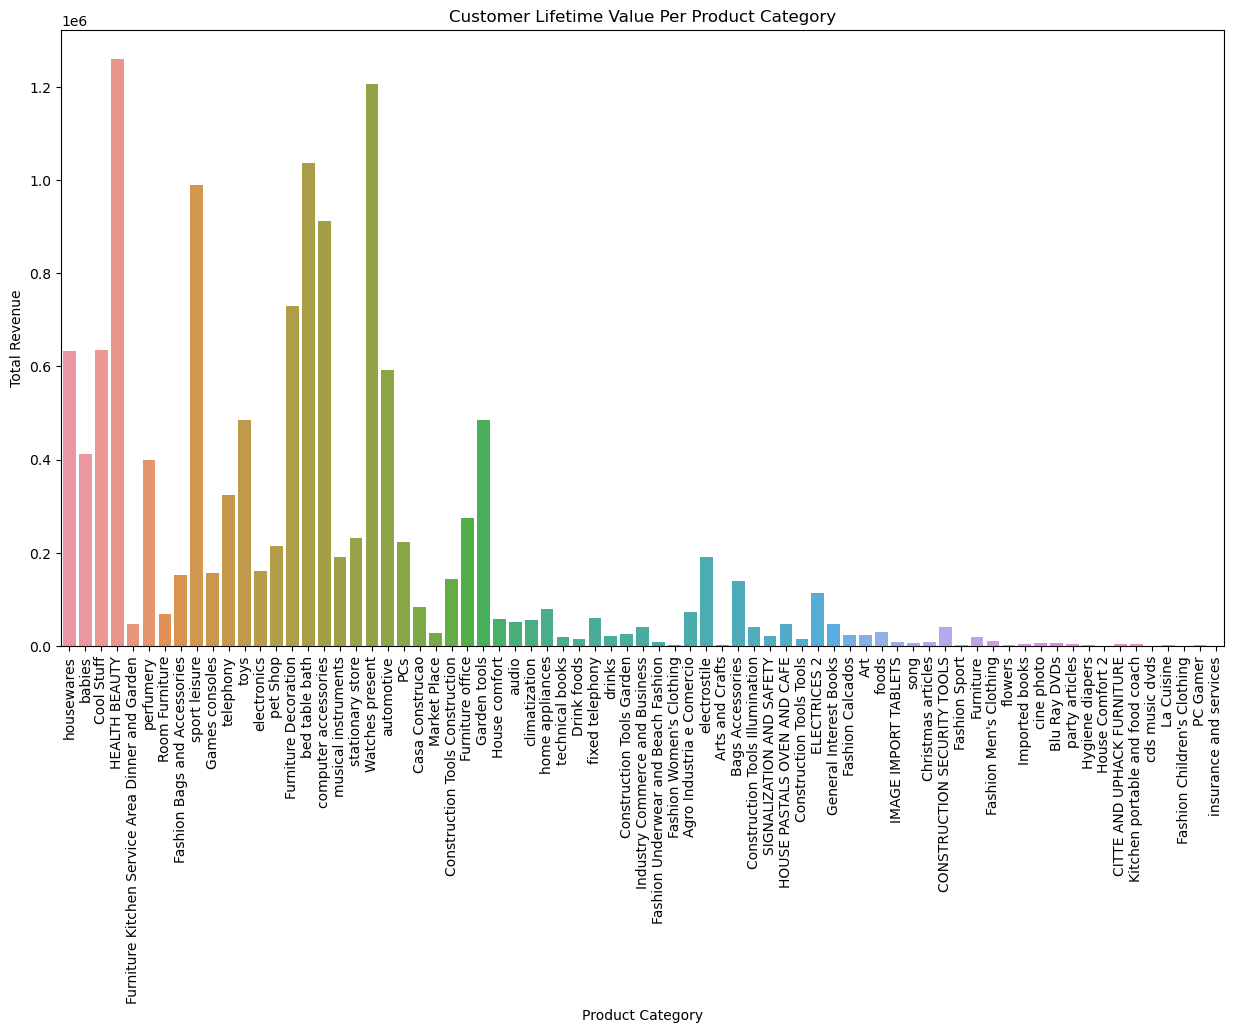

In [9]:
# 7. Calculate the customer lifetime value per product category.
cursor.execute("""
SELECT p.product_category, 
       SUM(oi.price) as total_revenue 
FROM order_items oi 
JOIN products p ON oi.product_id = p.product_id 
JOIN orders o ON oi.order_id = o.order_id 
GROUP BY p.product_category;
""")
result = cursor.fetchall()

# Convert the result to a DataFrame
lifetime_value_category_df = pd.DataFrame(result, columns=['Product Category', 'Total Revenue'])

# Plot the customer lifetime value per product category as a bar plot
plt.figure(figsize=(15, 8))
sns.barplot(data=lifetime_value_category_df, x='Product Category', y='Total Revenue')
plt.title('Customer Lifetime Value Per Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.show()

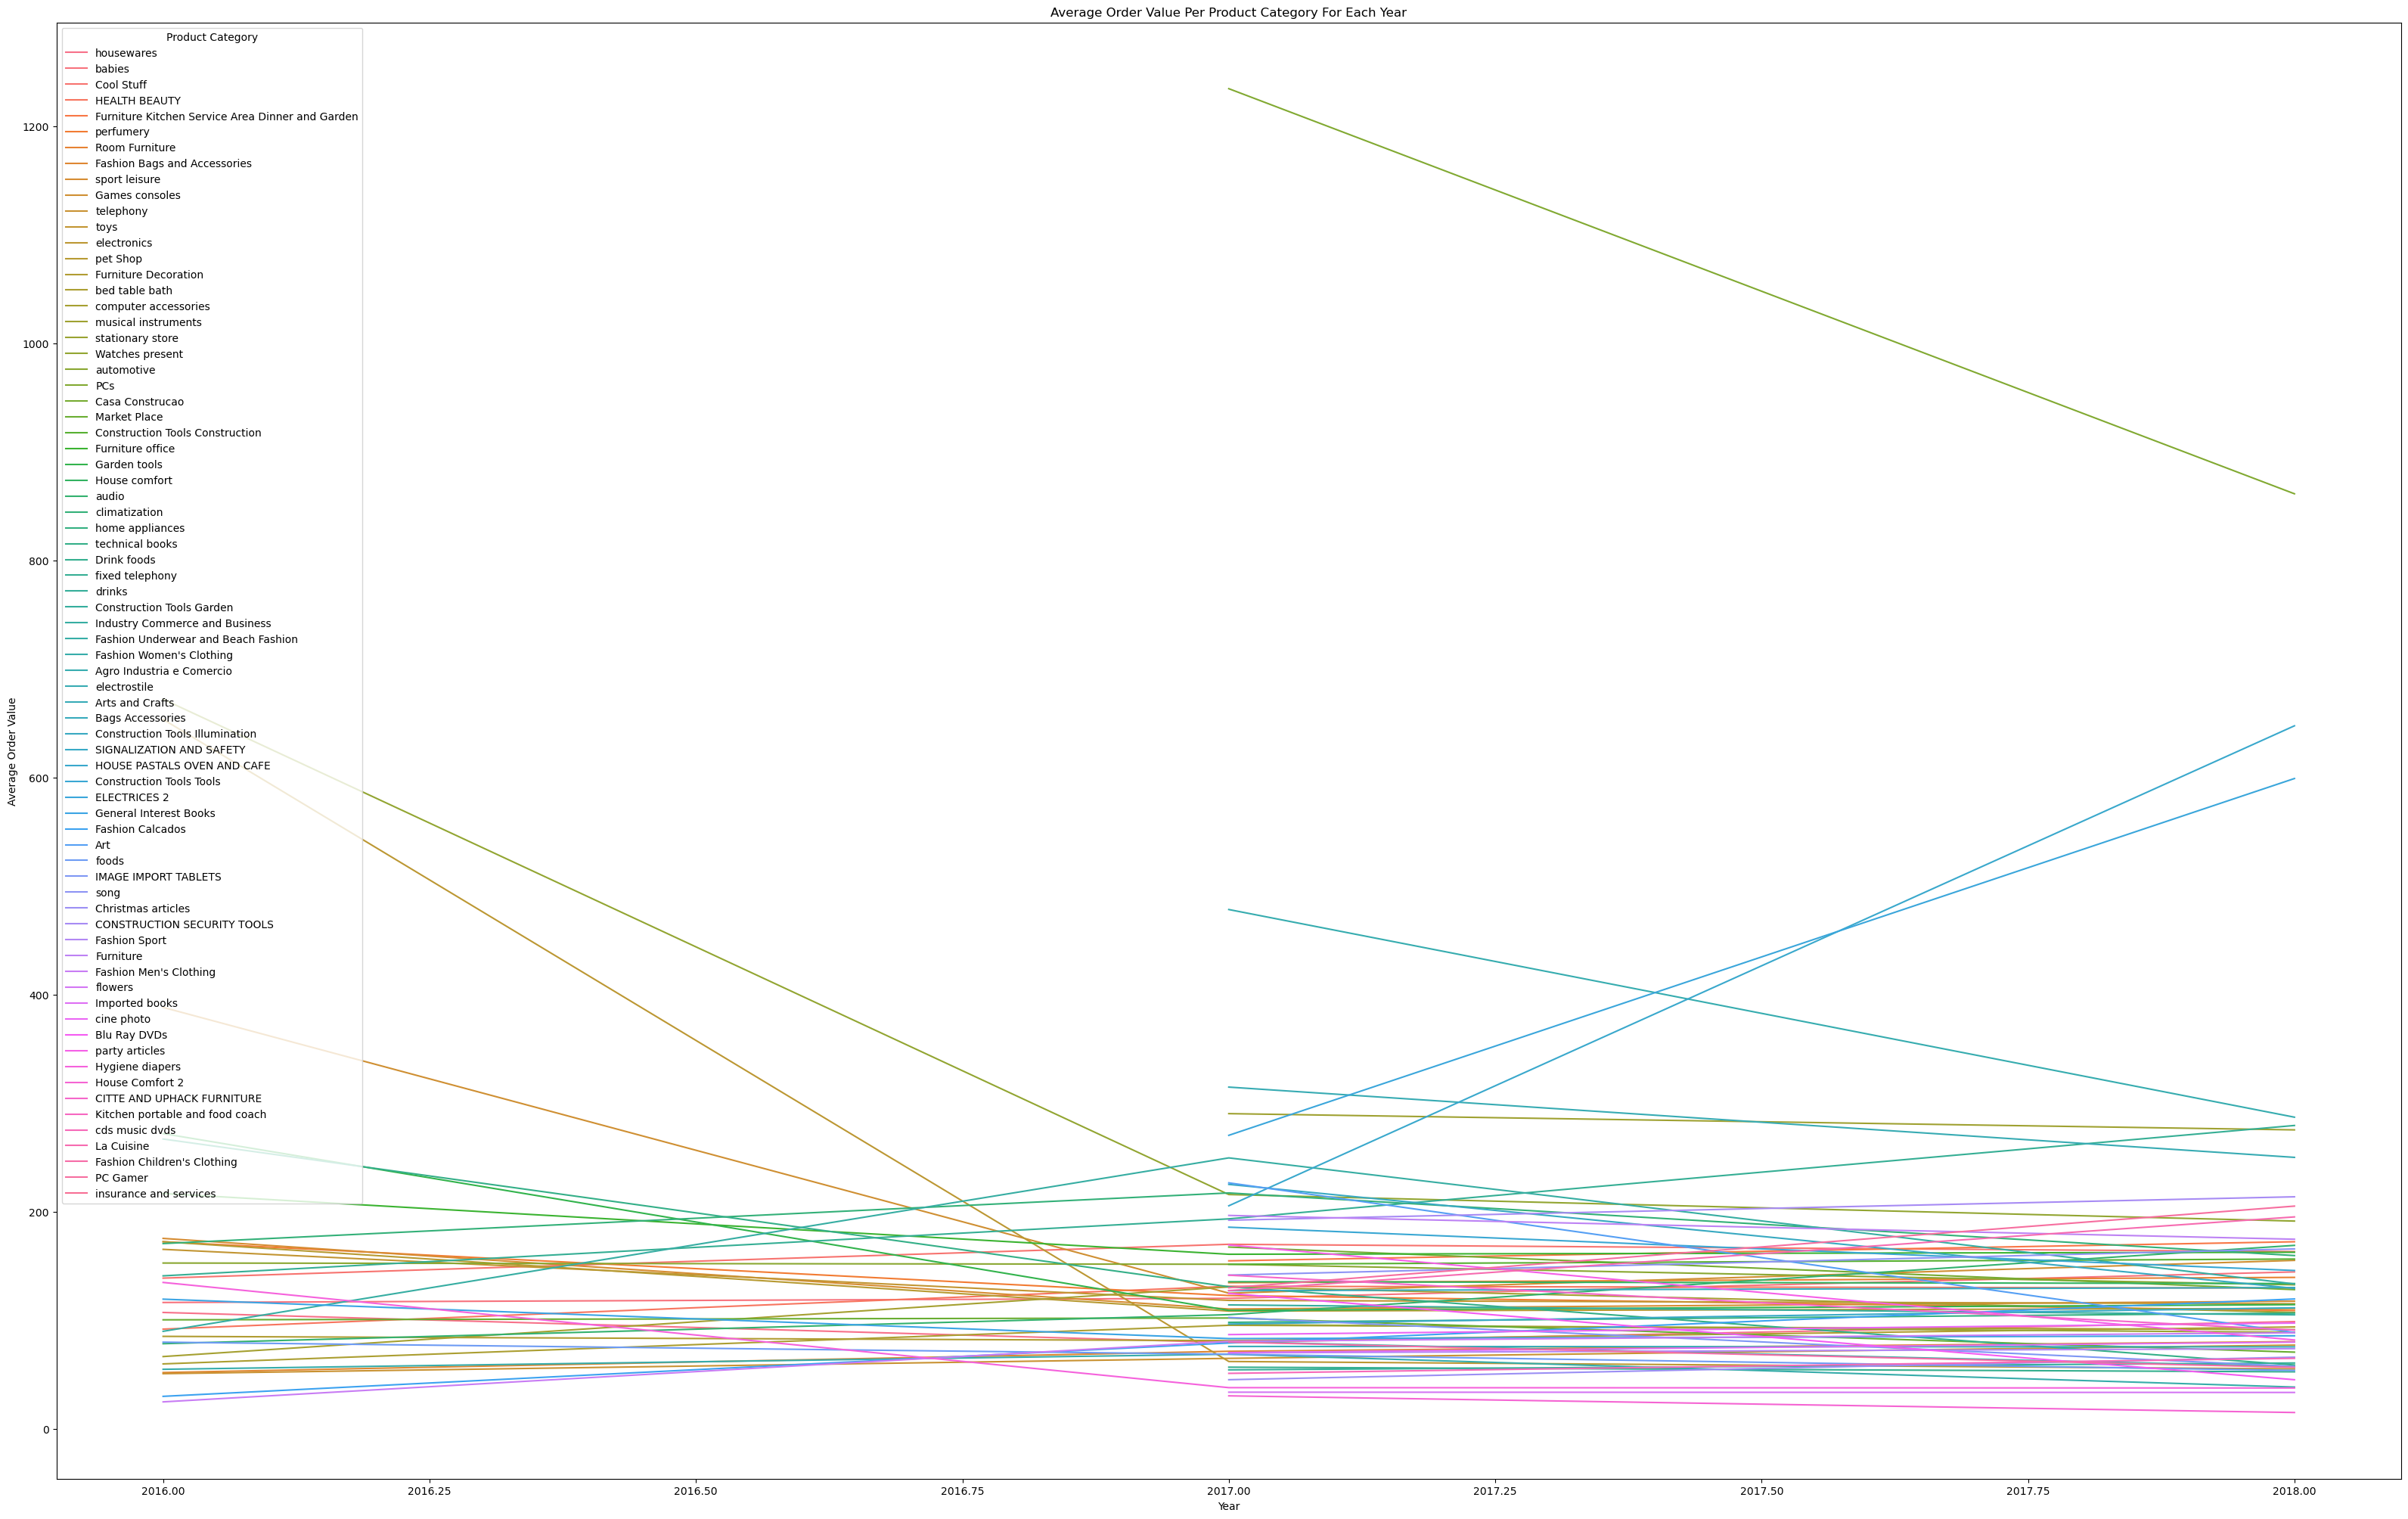

In [10]:
# 8. Determine the average order value per product category for each year.
cursor.execute("""
SELECT p.product_category, 
       YEAR(o.order_purchase_timestamp) as year, 
       AVG(oi.price) as avg_order_value 
FROM order_items oi 
JOIN products p ON oi.product_id = p.product_id 
JOIN orders o ON oi.order_id = o.order_id 
GROUP BY p.product_category, year;
""")
result = cursor.fetchall()

# Convert the result to a DataFrame
avg_order_value_df = pd.DataFrame(result, columns=['Product Category', 'Year', 'Average Order Value'])

# Plot the average order value per product category for each year as a line plot
plt.figure(figsize=(40, 25))
sns.lineplot(data=avg_order_value_df, x='Year', y='Average Order Value', hue='Product Category')
plt.title('Average Order Value Per Product Category For Each Year')
plt.xlabel('Year')
plt.ylabel('Average Order Value')
plt.show()

In [11]:
# Close connection
cursor.close()
connection.close()